# MLT model #1
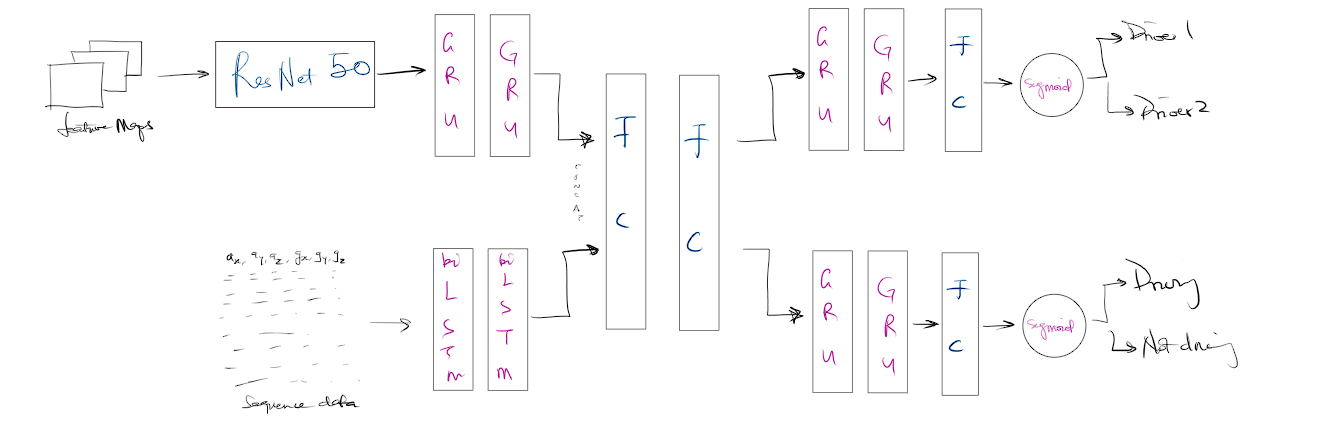
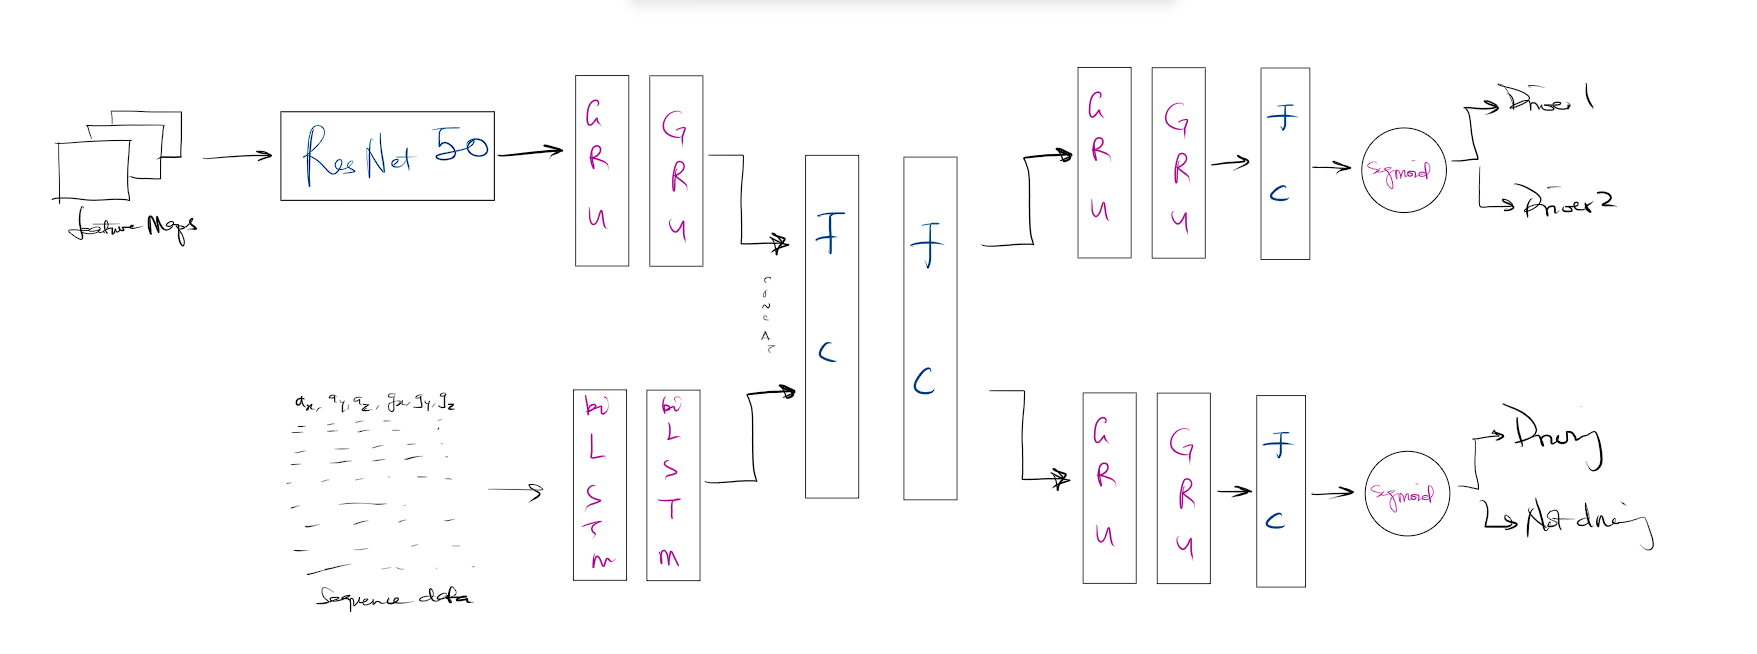
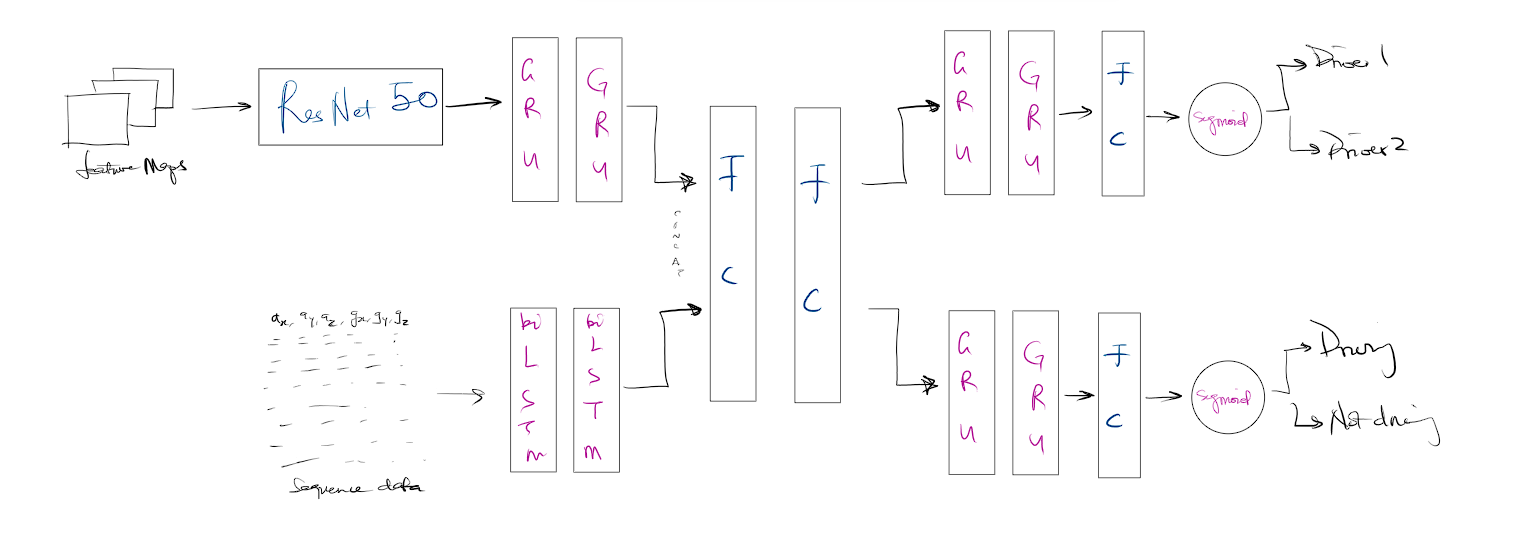
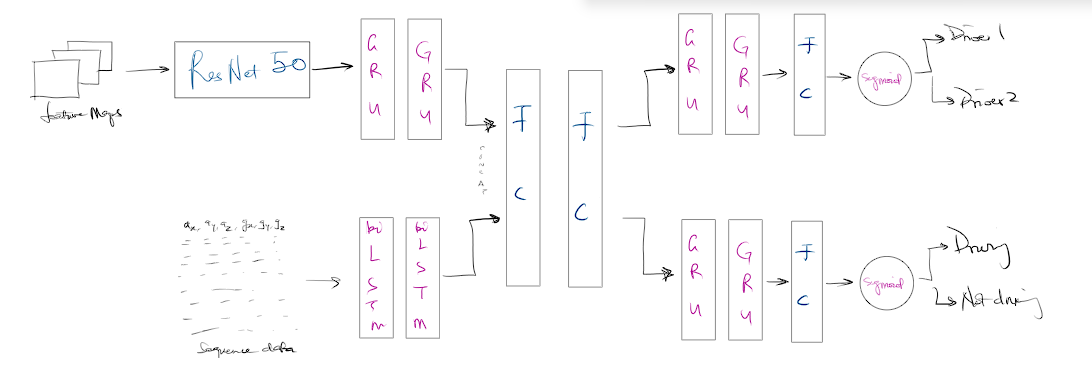
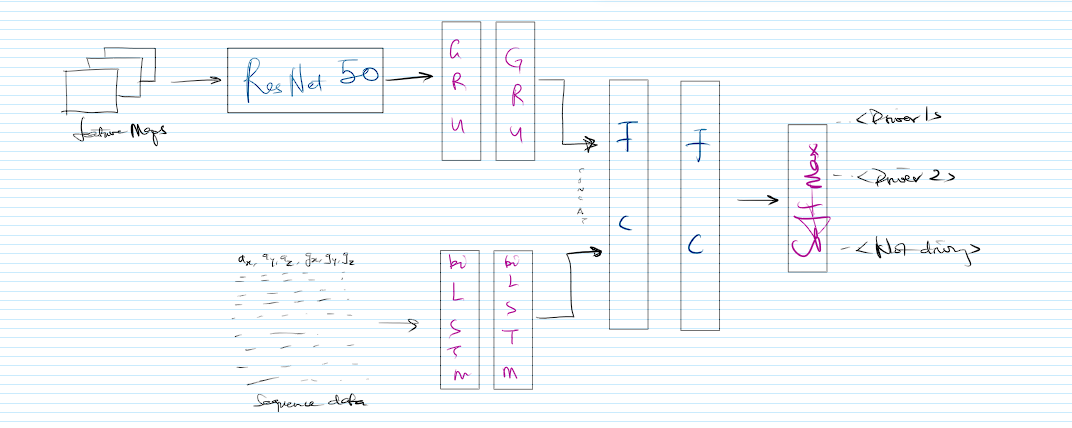

Let's get the feature maps and sequence data in;

In [1]:
import numpy as np
import torch

In [2]:
# feature maps data
X_fmap = np.load('./data/feature_maps_labels/full_feature_maps.npy')
X_fmap = torch.tensor(X_fmap, dtype=torch.float32)
y_fmap = np.load('./data/feature_maps_labels/full_labels.npy')
y_fmap = torch.tensor(y_fmap, dtype=torch.float32)
#flags_fmap = np.load('./data/feature_maps_labels/train_flags_fmaps.npy') # flags to identify which example to train
#flags_fmap = torch.tensor(flags_fmap, dtype=torch.float32)

# sequence data for biLSTM
X_seq = np.load('./data/lstm_features_labels/lstm_features_112.npy')
X_seq = torch.tensor(X_seq, dtype=torch.float32)
y_seq = np.load('./data/lstm_features_labels/lstm_labels_112.npy')
y_seq = torch.tensor(y_seq, dtype=torch.float32)

# Choose "car" as the positive class while the rest as negative
y_mapped = torch.where(y_seq == 5, torch.tensor(1.), torch.tensor(0.))
y_seq = y_mapped

In [3]:
# confirming length of X_fmap is the same as X_seq
assert (len(X_fmap) == len(X_seq)) & (len(y_fmap) == len(y_seq))

Recall that 0 = `Non-driving`, 1 = `User1`, and 2 = `User3`

In [4]:
# feature map labels without applying flag shows 3 classes
y_fmap.unique()

tensor([0., 1., 2.])

In [5]:
# # after applying flag it's now a binary class
# y_fmap[flags_fmap == 1.0].unique()

In [6]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split

In [7]:
class CombinedDataset(Dataset):
      def __init__(self, sequences, seq_labels, feature_maps, fmap_labels):#, flags):
            self.sequences = sequences
            self.seq_labels = seq_labels
            self.feature_maps = feature_maps
            self.fmap_labels = fmap_labels
            #self.flags = flags # fmaps flags

      def __len__(self):
            return len(self.sequences)  # Assuming all inputs are of equal length

      def __getitem__(self, idx):
            return {
                  'sequences': self.sequences[idx],
                  'seq_labels': self.seq_labels[idx],
                  'feature_maps': self.feature_maps[idx],
                  'fmap_labels': self.fmap_labels[idx],
                  #'flags': self.flags[idx]
            }


In [8]:
def create_combined_dataloaders(sequences, seq_labels, feature_maps, fmap_labels, k=5, batch_size=16, random_seed=42):
      '''Create dataloaders out of the combined dataset'''
      kf = KFold(n_splits=k, shuffle=True, random_state=random_seed)
      dataloaders = []

      for train_index, val_index in kf.split(sequences):
            train_sequences, val_sequences = sequences[train_index], sequences[val_index]
            train_seq_labels, val_seq_labels = seq_labels[train_index], seq_labels[val_index]
            train_feature_maps, val_feature_maps = feature_maps[train_index], feature_maps[val_index]
            train_fmap_labels, val_fmap_labels = fmap_labels[train_index], fmap_labels[val_index]
            #train_flags, val_flags = flags[train_index], flags[val_index]

            train_dataset = CombinedDataset(train_sequences, train_seq_labels, train_feature_maps, train_fmap_labels)#, train_flags)
            validation_dataset = CombinedDataset(val_sequences, val_seq_labels, val_feature_maps, val_fmap_labels)#, val_flags)

            # is there a need to set drop_last as False?
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
            validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

            dataloaders.append((train_loader, validation_loader))

      return dataloaders


In [9]:
import torch
import torch.nn as nn
from torchvision import models

In [10]:
class BiLSTMNetwork(nn.Module):
      def __init__(self, input_size, hidden_size, num_layers):
            super(BiLSTMNetwork, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

      def forward(self, x):
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
            return out[:, -1, :]  # Return the last time step

class ResNet50_GRU(nn.Module):
      def __init__(self, hidden_size, num_layers):
            super(ResNet50_GRU, self).__init__()
            self.resnet50 = models.resnet50(weights='DEFAULT')
            # freeze weights
            for param in self.resnet50.parameters():
                  param.requires_grad = False
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(0.5)
            self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.5)

      def forward(self, x):
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(x.size(0), 7*7, 2048)
            gru_out, _ = self.gru(features)
            return gru_out[:, -1, :]  # Return the last time step

class MultitaskModel(nn.Module):
      def __init__(self, input_size, hidden_size, num_layers):
            super(MultitaskModel, self).__init__()
            self.lstm_network = BiLSTMNetwork(input_size, hidden_size, num_layers)
            self.resnet_gru_network = ResNet50_GRU(hidden_size, num_layers)

            # share fully connected layers
            self.fc1 = nn.Linear(hidden_size * 3, hidden_size)  # Adjusted for the concatenated input size
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.relu = nn.ReLU()

            # task-specific GRUs
            self.gru_driver = nn.GRU(hidden_size, hidden_size, num_layers=2, batch_first=True, dropout=0.5)
            self.gru_transport = nn.GRU(hidden_size, hidden_size, num_layers=2, batch_first=True, dropout=0.5)

            # Task-specific fully connected layers
            self.fc_driver = nn.Linear(hidden_size, 3) # now we're looking at multiclass classification
            self.fc_transport = nn.Linear(hidden_size, 1)
            
            # sigmoid for binary classification
            self.sigmoid = nn.Sigmoid()
            # self.softmax = nn.Softmax(dim=1)  # No need since I'm using CrossEntropyLoss which applies it internally

      def forward(self, x_lstm, x_resnet): #,flags): 
            lstm_out = self.lstm_network(x_lstm)
            resnet_gru_out = self.resnet_gru_network(x_resnet)
            
            # mask the resnet_gru_out based on flags (Why? Not all datapoints are to be trained as they might not be driving data)
            #resnet_gru_out = resnet_gru_out * flags.view(-1, 1)

            # combine lstm_out and resnet_gru_out, considering masked values
            combined_features = torch.cat((lstm_out, resnet_gru_out), dim=1)

            # shared fully connected layers
            shared_out = self.fc1(combined_features)
            shared_out = self.relu(shared_out)
            shared_out = self.fc2(shared_out)
            shared_out = self.relu(shared_out)

            ## task specific branches
            # Driver identification branch
            driver_gru_out, _ = self.gru_driver(shared_out.unsqueeze(1))
            driver_out = self.fc_driver(driver_gru_out[:, -1, :])

            # Transport classification branch
            transport_gru_out, _ = self.gru_transport(shared_out.unsqueeze(1))
            transport_out = self.sigmoid(self.fc_transport(transport_gru_out[:, -1, :]))
            
            return transport_out, driver_out

In [11]:
import time
import os

def safe_save_model(model, save_path, epoch, optimizer, loss):
      temp_save_path = save_path + ".tmp"
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
      }, temp_save_path)
      os.replace(temp_save_path, save_path)

def train_and_evaluate(model, train_loader, val_loader, num_epochs, 
                       criterion_transport, criterion_driver, optimizer, scheduler, device,
                       alpha=1.0, beta=1.0, save_path=None):
      train_loss_history = []
      val_loss_history = []
      train_acc_transport_history = []
      val_acc_transport_history = []
      train_acc_driver_history = []
      val_acc_driver_history = []


      for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_transport_train = 0
            total_transport_train = 0
            correct_driver_train = 0
            total_driver_train = 0

            for batch in train_loader:
                  sequences = batch['sequences'].to(device)
                  seq_labels = batch['seq_labels'].to(device)
                  feature_maps = batch['feature_maps'].to(device)
                  fmap_labels = batch['fmap_labels'].to(device)
                  # flags = batch['flags'].to(device)

                  optimizer.zero_grad()

                  # Forward pass
                  transport_out, driver_out = model(sequences, feature_maps)#, flags)

                  # Compute transport classification loss
                  loss_transport = criterion_transport(transport_out.flatten(), seq_labels.float())

                  # Compute driver identification loss only for flagged samples
                  loss_driver = criterion_driver(driver_out, fmap_labels.long())

                  # # weighted sum of losses
                  # print(loss_transport, loss_driver)
                  total_loss = alpha * loss_transport + beta * loss_driver
                  total_loss.backward()

                  # Perform optimization step
                  optimizer.step()

                  running_loss += total_loss.item()

                  # calculate accuracy for transport classification 
                  predicted_transport = (transport_out > 0.5).int()
                  correct_transport_train += (predicted_transport == seq_labels).sum().item()
                  total_transport_train += seq_labels.size(0)

                  # Calculate accuracy for driver identification
                  _, predicted_driver = torch.max(driver_out, 1)
                  correct_driver_train += (predicted_driver == fmap_labels).sum().item()
                  total_driver_train += fmap_labels.size(0)


            train_loss_history.append(running_loss / len(train_loader))
            train_acc_transport_history.append(correct_transport_train / total_transport_train)
            train_acc_driver_history.append(correct_driver_train / total_driver_train)

            model.eval()
            val_loss = 0.0
            correct_transport_val = 0
            total_transport_val = 0
            correct_driver_val = 0
            total_driver_val = 0

            with torch.no_grad():
                  for batch in val_loader:
                        sequences = batch['sequences'].to(device)
                        seq_labels = batch['seq_labels'].to(device)
                        feature_maps = batch['feature_maps'].to(device)
                        fmap_labels = batch['fmap_labels'].to(device)
                        #flags = batch['flags'].to(device)

                        transport_out, driver_out = model(sequences, feature_maps)#, flags)

                        loss_transport = criterion_transport(transport_out.flatten(), seq_labels.float())
                        loss_driver = criterion_driver(driver_out, fmap_labels.long())

                        total_loss = alpha * loss_transport + beta * loss_driver
                        val_loss += total_loss.item()

                        predicted_transport = (transport_out > 0.5).int()
                        correct_transport_val += (predicted_transport == seq_labels).sum().item()
                        total_transport_val += seq_labels.size(0)

                        _, predicted_driver = torch.max(driver_out, 1)
                        correct_driver_val += (predicted_driver == fmap_labels).sum().item()
                        total_driver_val += fmap_labels.size(0)



            val_loss_history.append(val_loss / len(val_loader))
            val_acc_transport_history.append(correct_transport_val / total_transport_val)
            val_acc_driver_history.append(correct_driver_val / total_driver_val)

            scheduler.step()

            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss_history[-1]:.4f}, Train Transport Acc: {train_acc_transport_history[-1]:.4f}, '
                  f'Train Driver Acc: {train_acc_driver_history[-1]:.4f}, '
                  f'Val Loss: {val_loss_history[-1]:.4f}, Val Transport Acc: {val_acc_transport_history[-1]:.4f}, '
                  f'Val Driver Acc: {val_acc_driver_history[-1]:.4f}')
            
            # Save checkpoint
            if save_path:
                  for _ in range(5):  # Retry up to 5 times
                        try:
                              safe_save_model(model, save_path, epoch, optimizer, total_loss)
                              break
                        except Exception as e:
                              print(f"Error saving model: {e}. Retrying in 1 second.")
                              time.sleep(1)

      return model, train_loss_history, val_loss_history, train_acc_transport_history, val_acc_transport_history, \
            train_acc_driver_history, val_acc_driver_history

In [12]:
def test_model(model, test_loader, criterion_transport, criterion_driver, device, alpha=1.0, beta=1.0):
      model.eval()
      test_loss = 0.0
      correct_test_transport = 0
      correct_test_driver = 0
      total_test_transport = 0
      total_test_driver = 0

      with torch.no_grad():
            for batch in test_loader:
                  sequences = batch['sequences'].to(device)
                  seq_labels = batch['seq_labels'].to(device)
                  feature_maps = batch['feature_maps'].to(device)
                  fmap_labels = batch['fmap_labels'].to(device)
                  #flags = batch['flags'].to(device)

                  transport_out, driver_out = model(sequences, feature_maps)#, flags)

                  # Compute losses
                  loss_transport = criterion_transport(transport_out.flatten(), seq_labels.float())
                  loss_driver = criterion_driver(driver_out, fmap_labels.long())

                  total_loss = alpha * loss_transport + beta * loss_driver
                  test_loss += total_loss.item()

                  # Calculate accuracies
                  predicted_transport = (transport_out > 0.5).int()
                  correct_test_transport += (predicted_transport == seq_labels).sum().item()
                  total_test_transport += seq_labels.size(0)

                  _, predicted_driver = torch.max(driver_out, 1)
                  correct_test_driver += (predicted_driver == fmap_labels).sum().item()
                  total_test_driver += fmap_labels.size(0)

      test_loss /= len(test_loader)
      test_accuracy_transport = correct_test_transport / total_test_transport
      test_accuracy_driver = correct_test_driver / total_test_driver

      print(f'   Test Loss: {test_loss:.4f}, Test Transport Accuracy: {test_accuracy_transport:.4f}, '
            f'Test Driver Accuracy: {test_accuracy_driver:.4f}')

      return test_loss, test_accuracy_transport, test_accuracy_driver


Getting the test data first; [No need for this later on as I've already kept test data from the beginning]

In [13]:
len(X_seq), len(X_fmap), len(y_fmap), len(y_seq)

(732, 732, 732, 732)

In [14]:
# Split data into train/val/test. Stratify by flags so that both sets have representative driving data
train_val_idx, test_idx = train_test_split(np.arange(len(y_fmap)), test_size=0.2, random_state=42, stratify=y_fmap)

# prep test dat
test_data = CombinedDataset(X_seq[test_idx], y_seq[test_idx], X_fmap[test_idx], y_fmap[test_idx])#, flags_fmap[test_idx])

# Prepare test DataLoader
batch_size = 16
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

In [16]:
# Parameters
input_size = 6  # Define input size for BiLSTM
hidden_size = 64  # Define hidden size for both LSTM and GRU
num_layers = 2  # Define number of layers for both LSTM and GRU
num_epochs = 10

# ensure that your batch_size captures majority of the data
# given it's size because you set drop_last=False for your dataloader
batch_size = 16
k_folds = 5
random_seed = 42

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# Create dataloaders for k-fold cross-validation
train_val_dataloaders = create_combined_dataloaders(X_seq[train_val_idx], y_seq[train_val_idx], 
                                                    X_fmap[train_val_idx], y_fmap[train_val_idx],
                                                    k=k_folds, batch_size=batch_size, random_seed=random_seed)

# Loss and optimizer
criterion_transport = nn.BCELoss()
criterion_driver = nn.CrossEntropyLoss()
learning_rate = 0.001
learning_rate_decay = 0.95

In [18]:
# arr for storing hist
loss_hist = []
acc_hist = []

# K-Fold Cross Validation
for fold, (train_loader, val_loader) in enumerate(train_val_dataloaders):
      print(f'Fold {fold + 1}/{k_folds}')
      
      model = MultitaskModel(input_size, hidden_size, num_layers).to(device)
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: learning_rate * (learning_rate_decay ** epoch))
      

      save_path = f'./model_checkpoint/MTL_model_fold_{fold + 1}.pth'

      model, train_loss_history, val_loss_history, _, _, train_acc_history, val_acc_history = train_and_evaluate(
                  model, train_loader, val_loader, num_epochs, criterion_transport, criterion_driver,
                  optimizer, scheduler, device, save_path=save_path
                  )
      
      loss_hist.append([train_loss_history, val_loss_history])
      acc_hist.append([train_acc_history, val_acc_history])
      # Save losses and accuracies
      #np.save(f'train_losses_fold_{fold + 1}.npy', np.array(train_loss_history))
      #np.save(f'val_losses_fold_{fold + 1}.npy', np.array(val_loss_history))
      #np.save(f'train_accuracies_fold_{fold + 1}.npy', np.array(train_acc_history))
      #np.save(f'val_accuracies_fold_{fold + 1}.npy', np.array(val_acc_history))

Fold 1/5
Epoch [1/10], Train Loss: 1.7922, Train Transport Acc: 12.1624, Train Driver Acc: 0.1154, Val Loss: 1.7902, Val Transport Acc: 12.3419, Val Driver Acc: 0.1197
Epoch [2/10], Train Loss: 1.7923, Train Transport Acc: 12.1624, Train Driver Acc: 0.1261, Val Loss: 1.7902, Val Transport Acc: 12.3419, Val Driver Acc: 0.1197
Epoch [3/10], Train Loss: 1.7913, Train Transport Acc: 12.1880, Train Driver Acc: 0.1282, Val Loss: 1.7899, Val Transport Acc: 12.3419, Val Driver Acc: 0.1197
Epoch [4/10], Train Loss: 1.7908, Train Transport Acc: 12.1880, Train Driver Acc: 0.1389, Val Loss: 1.7898, Val Transport Acc: 12.3419, Val Driver Acc: 0.1197
Epoch [5/10], Train Loss: 1.7900, Train Transport Acc: 12.1624, Train Driver Acc: 0.1261, Val Loss: 1.7895, Val Transport Acc: 12.3419, Val Driver Acc: 0.1197
Epoch [6/10], Train Loss: 1.7898, Train Transport Acc: 12.1624, Train Driver Acc: 0.1261, Val Loss: 1.7890, Val Transport Acc: 12.3419, Val Driver Acc: 0.1197
Epoch [7/10], Train Loss: 1.7904, Tra

In [105]:
# from torch.utils.tensorboard import SummaryWriter

# # Create a summary writer
# writer = SummaryWriter(log_dir='logs')

# # Example inputs for the model
# example_sequences = X_seq[test_idx].to(device)
# example_feature_maps = X_fmap[test_idx].to(device)
# #example_flags = flags_fmap[test_idx].to(device)

# # Forward pass to log the graph
# writer.add_graph(model, (example_sequences, example_feature_maps))

# # Close the writer
# writer.close()


In [106]:
# !tensorboard --logdir=logs

^C


In [117]:
test_loss, test_accuracy_transport, test_accuracy_driver = test_model(
      model, test_loader, criterion_transport, criterion_driver, device)

   Test Loss: 1.7802, Test Transport Accuracy: 12.0340, Test Driver Accuracy: 0.0884
